In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional
from keras.optimizers import Adam

In [2]:
df = pd.read_csv('/content/drive/My Drive/Sharer.pw/dataset_final.csv')
df.set_index(pd.to_datetime(df.date),inplace=True)
df.drop(['Unnamed: 0','date'],axis=1,inplace=True)
df.head()

#split the into train and test dataset
test_data = pd.concat([df['2020-02'],df['2020-03'],df['2020-04']],axis=0)
train_data = df[:-len(test_data)]

train_data.head()

,btc_price,gold_price,oil_wti_price,sp500_close,btc_num_trans,btc_google_search,btc_dr,gold_dr,oil_dr,sp500_dr,BVOL,GVOL,OVOL,VIX
date,,,,,,,,,,,,,,
2015-01-15,211.91,1352.8,46.37,1992.67,102309.0,3,0.568670,0.021141,-0.044705,-0.009291,0.853974,0.344132,0.344950,22.39
2015-01-16,199.46,1364.9,48.49,2019.42,104699.0,3,-0.060548,0.008905,0.044705,0.013335,0.857286,0.348453,0.346061,20.95
2015-01-20,208.00,1377.4,46.79,2022.55,98485.0,3,0.041924,0.009116,-0.035688,0.001549,0.857176,0.348518,0.346647,19.89
2015-01-21,225.51,1378.4,47.85,2032.12,98485.0,3,0.080826,0.000726,0.022402,0.004720,0.893605,0.350149,0.347336,18.85
2015-01-22,226.32,1390.2,45.93,2063.15,93698.0,3,0.003585,0.008524,-0.040953,0.015154,0.904949,0.351242,0.343230,16.40


In [3]:
train_data = train_data[['btc_dr','gold_dr','oil_dr','sp500_dr']]

In [4]:
def time_lag(df,col,lag):
  if lag == 1:
    shifted_series = df[col].shift(1)
    df['t-1']  = shifted_series
    df.dropna(inplace=True)
    return series
  else :
    for i in range(1,lag+1):
      print(df.shape)
      lag_val = 't-'+str(i)
      shifted_series = df.iloc[:,-1:].shift(1)
      df[lag_val] = shifted_series
      df.dropna(inplace=True)
    return df

In [5]:
btc_dr_lagged = time_lag(pd.DataFrame(train_data.btc_dr),'btc_dr',4)
gold_dr_lagged = pd.DataFrame(train_data.gold_dr.shift(4).dropna())
data = pd.concat([btc_dr_lagged.reset_index(),gold_dr_lagged.reset_index()],axis=1)
data.drop('date',axis=1,inplace=True)
data.head()

(1262, 1)
(1261, 2)
(1260, 3)
(1259, 4)


,btc_dr,t-1,t-2,t-3,t-4,gold_dr
0,0.003585,0.080826,0.041924,-0.060548,0.568670,0.021141
1,0.037636,0.003585,0.080826,0.041924,-0.060548,0.008905
2,0.138836,0.037636,0.003585,0.080826,0.041924,0.009116
3,-0.027447,0.138836,0.037636,0.003585,0.080826,0.000726
4,-0.106550,-0.027447,0.138836,0.037636,0.003585,0.008524


In [6]:
X = data.values

In [7]:
X_train = []
y_train = []

# Number of days we want top predict into the future
n_future = len(test_data)   
# Number of past days we want to use to predict the future
timesteps = 5    
for i in range(timesteps, len(X) - n_future +1):
    X_train.append(X[i - timesteps:i, 0:X.shape[1] - 1])
    y_train.append(X[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(f'X_train shape = {X_train.shape}.')
print(f'y_train shape = {y_train.shape}.')

X_train shape = (1197, 5, 5).
y_train shape = (1197, 1).


In [31]:
#defining LSTM model
def lstm_model():
  model = Sequential()
  model.add(LSTM(32,input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dense(1))
  adam = Adam(learning_rate=0.0001, beta_1=100, beta_2=100, epsilon=1e-07)
  model.compile(optimizer='adam',loss='mae')
  return model
model = lstm_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train,y_train,epochs=30,shuffle=False)

Epoch 1/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0304
Epoch 2/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0299
Epoch 3/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0296
Epoch 4/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0296
Epoch 5/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0296
Epoch 6/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0297
Epoch 7/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0300
Epoch 8/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0300
Epoch 9/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0300
Epoch 10/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0300
Epoch 11/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0300
Epoch 12/30
38/38 [==============================] - 0s 3ms/step - loss: 0.0301
Epoch 13/30
38/38 [==============================

In [33]:
#forecast bitcoin daily returns
pred = model.predict(X_train[-n_future:])

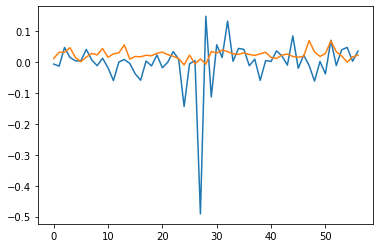

In [34]:
plt.figure()
plt.plot(test_data.btc_dr.values)
plt.plot(pred*10)